In [1]:
using OffsetArrays, Plots, ProgressMeter

## Factor update

In [2]:
# Convolution with clamping
function convolve(p1, p2)
    N = max(lastindex(p1), lastindex(p2))
    q = fill(0.0,-N:N)
    for f1 ∈ eachindex(p1)
        for f2 ∈ eachindex(p2)
            q[clamp(f1+f2, -N, N)] += p1[f1]*p2[f2]
        end
    end
    q ./= sum(q)
end

# convolution for function whose domain is {-1,+1}
# represented as tuples where the first index is +1, the second is -1
convolve_spin(h1::Tuple, h2::Tuple) = (h1[1]*h2[1]+h1[2]*h2[2], h1[1]*h2[2]+h1[2]*h2[1]) 

convolve_spin (generic function with 1 method)

In [3]:
function iter_factor_asymm(q, k)
    p = zero(q)
    N = lastindex(q)
    qs = (sum(q[1:N]), sum(q[-N:-1]))
    qs = qs ./ sum(qs)
    ps = (1.0, 0.0)    # neutral el for spin convolution
    for u in 1:N
        ps = convolve_spin(qs,ps)
    end
    
    for u in 1:N
        v1 = q[u] + q[-u]
        v2 = sum([q[h]+q[-h] for h in u+1:N], init=0.0)
        v = (v1+v2)^k-v2^k
        p[u] = v*ps[1]
        p[-u] = v*ps[2]
    end
    
    p[0] = 1-(1-q[0])^k
    p ./ sum(p)
end

iter_factor_asymm (generic function with 1 method)

## Variable update

In [4]:
function iter_var_asymm(p, d::Int, ps::Tuple)
    q = zero(p)
    q[-1:1] .= [ps[2], 0.0, ps[1]]
    for _ in 1:d
        q = convolve(q, p)
    end
    q
end

iter_var_asymm (generic function with 1 method)

## Full computation

In [5]:
function overlap_factor_asymm(q,k) 
    p = iter_factor_asymm(q,k)
    ovl = 2 * sum(u*p[-u] for u in 1:lastindex(p))
end

overlap_factor_asymm (generic function with 1 method)

In [6]:
function RS_asymm(Pk, Λ, psrc=(.5,.5); N=100, tol=1e-5, maxiter=100, damp=0.9)
    ks = [k for k in eachindex(Pk) if Pk[k] > tol]
    ds = [d for d in eachindex(Λ) if Λ[d] > tol]
    @assert sum(Pk[ks]) ≈ 1 && sum(Λ[ds]) ≈ 1
    p = fill(0.0, -N:N); p[-N:-1].=psrc[2]; p[1:N].=psrc[1]; p[0] = max(psrc...); p ./= sum(p)
    @showprogress for iter=1:maxiter
        q = sum(d*Λ[d]*iter_var_asymm(p, d-1, psrc) for d=ds)
        q ./= sum(q)
        p1 = sum(k*Pk[k]*iter_factor_asymm(q, k-1) for k=ks)
        p1 ./= sum(p1)
        err = maximum(abs, p1 - p); err < tol && (@show err iter; break)
        p .= p .* damp .+ p1 .* (1-damp)
    end
    α = sum(d*Λ[d] for d=ds) / sum(k*Pk[k] for k=ks)
    
    q = sum(d*Λ[d]*iter_var_asymm(p, d-1, psrc) for d=ds); #fia
    O = sum(abs(f)*q[f] for f=eachindex(q))
    q2 = sum((d-1)*Λ[d]*iter_var_asymm(p, d, psrc) for d=ds); #fi
    O -= sum(abs(f)*q2[f] for f=eachindex(q2))
    q ./= sum(q)
    O -= α*sum(Pk[k]*overlap_factor_asymm(q,k) for k=ks) #fa
    q = sum(d*Λ[d]*iter_var_asymm(p, d, psrc) for d=ds)  # belief
    1-α, (1-O)/2, p, q/sum(q)
end

RS_asymm (generic function with 2 methods)

In [221]:
Pk = [0,0,1]
Λ = [0.5,0.5,0]
R, D, p, q = RS_asymm(Pk, Λ, (1,0), N=500, maxiter=500)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


err = 9.254533240243834e-6
iter = 122


(0.5, -1.1107897490703067e-8, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  5.923146622422806e-9, 5.9113614851815286e-9, 5.89960967275148e-9, 5.887891061612584e-9, 5.876205528811895e-9, 5.864552951960437e-9, 5.852933209230137e-9, 5.841346179350752e-9, 5.829791741606866e-9, 5.8240091891257275e-9], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  9.915897258990785e-9, 9.89613084319396e-9, 9.876420430964653e-9, 9.85676581431061e-9, 9.837166786196405e-9, 9.817623140538171e-9, 9.798134672198424e-9, 9.778701176980793e-9, 9.759322451625012e-9, 3.1399417257920764e-8])

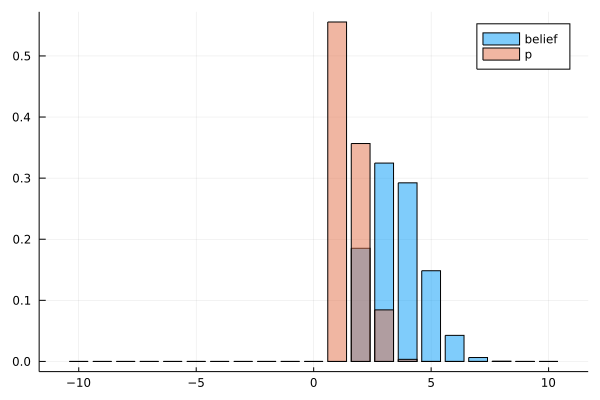

In [222]:
M = 10
qplot = OffsetArray(q[-M:M], -M-1)
pl = plot(collect(eachindex(qplot)),qplot.parent, label="belief", st=:bar, fillalpha=0.5)
pplot = OffsetArray(p[-M:M], -M-1)
plot!(pl, collect(eachindex(pplot)),pplot.parent, label="p", st=:bar, fillalpha=0.5)

## Explore values of f1

In [19]:
f1s = 0:0.1:0.9
N = 1000
qs0 = [fill(0.0,-N:N) for f1 in f1s]
for (i,f1) in pairs(f1s)
    println("--- degree $i of $(length(f1s)): f1=$f1 ---")
    flush(stdout)
    Lambda = [f1, 1-f1]
    Rho = [0,0,1]
    R, D, p, q = RS_asymm(Rho, Lambda, (1,0), N=N, maxiter=N)
    qs0[i] .= q
end

--- degree 1 of 10: f1=0.0 ---


Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


--- degree 2 of 10: f1=0.1 ---


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


err = 9.638330497253877e-6
iter = 162
--- degree 3 of 10: f1=0.2 ---


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


err = 9.553460999778968e-6
iter = 145
--- degree 4 of 10: f1=0.3 ---


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


err = 9.686349170756614e-6
iter = 135
--- degree 5 of 10: f1=0.4 ---


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


err = 9.56399348390341e-6
iter = 126
--- degree 6 of 10: f1=0.5 ---


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


err = 9.33592886143142e-6
iter = 122
--- degree 7 of 10: f1=0.6 ---


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


err = 9.613377350004004e-6
iter = 118
--- degree 8 of 10: f1=0.7 ---


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


err = 9.650646336123447e-6
iter = 112
--- degree 9 of 10: f1=0.8 ---


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


err = 9.111387050064756e-6
iter = 110
--- degree 10 of 10: f1=0.9 ---


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


err = 9.932418871039239e-6
iter = 110


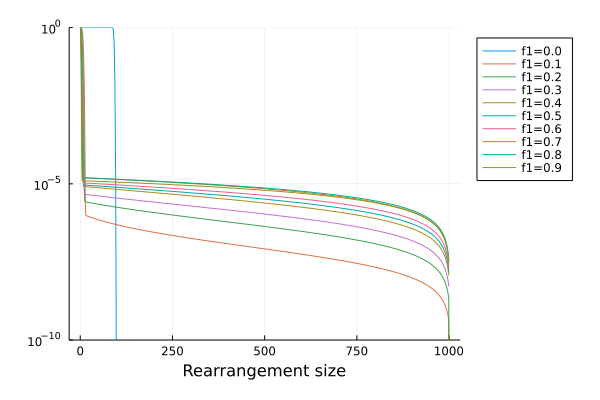

In [21]:
pl0 = Plots.Plot()
for (i,f1) in pairs(f1s)
    plot!(pl0, 0:lastindex(qs0[i]), (1 .- cumsum(qs0[i]))[0:end], label="f1=$(round(f1,digits=3))")
end
xlabel!(pl0,"Rearrangement size")
# title!(pl0, "f1 = 0.0")
plot!(pl0, margin=5*Plots.mm, legend=:outertopright, yaxis=((10^(-10), 1), :log10))

## Explore values of f3

In [301]:
f3s = 0.38:0.01:0.42
N = 3000
qs1 = [fill(0.0,-N:N) for f3 in f3s]
f1 = 0.0
for (i,f3) in pairs(f3s)
    println("--- degree $i of $(length(f3s)): f1=$f1, f3 = $f3 ---")
    flush(stdout)
    Lambda = [f1, 1-f3-f1, f3]
    Rho = [0,0,1]
    R, D, p, q = RS_asymm(Rho, Lambda, (1,0), N=N, maxiter=N)
    qs1[i] .= q
end

--- degree 1 of 5: f1=0.0, f3 = 0.38 ---


Progress: 100%|█████████████████████████████████████████| Time: 0:18:06


--- degree 2 of 5: f1=0.0, f3 = 0.39 ---


Progress:  67%|███████████████████████████▎             |  ETA: 0:05:59IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Progress: 100%|█████████████████████████████████████████| Time: 0:17:52


--- degree 5 of 5: f1=0.0, f3 = 0.42 ---


Progress:  34%|█████████████▉                           |  ETA: 0:11:58IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



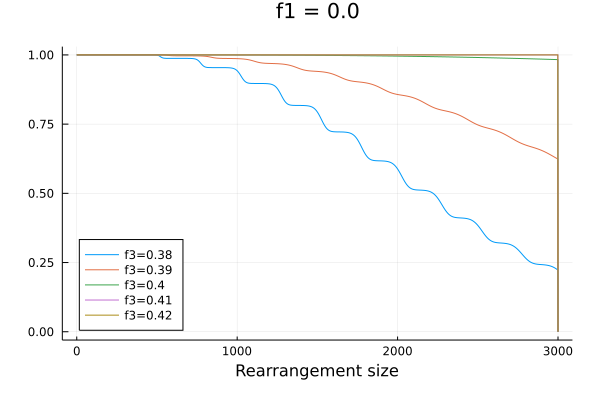

In [302]:
pl1 = Plots.Plot()
for (i,f3) in pairs(f3s)
    plot!(pl1, 0:lastindex(qs1[i]), (1 .- cumsum(qs1[i]))[0:end], label="f3=$(round(f3,digits=3))")
end
xlabel!(pl1,"Rearrangement size")
title!(pl1,"f1 = 0.0")
plot!(pl1, margin=5*Plots.mm, legend=:bottomleft)

In [303]:
f3s = 0.45:0.01:0.49
N = 3000
qs2 = [fill(0.0,-N:N) for f3 in f3s]
f1 = 0.01
for (i,f3) in pairs(f3s)
    println("--- degree $i of $(length(f3s)): f1=$f1, f3 = $f3 ---")
    flush(stdout)
    Lambda = [f1, 1-f3-f1, f3]
    Rho = [0,0,1]
    R, D, p, q = RS_asymm(Rho, Lambda, (1,0), N=N, maxiter=N)
    qs2[i] .= q
end

--- degree 1 of 5: f1=0.01, f3 = 0.45 ---


Progress: 100%|█████████████████████████████████████████| Time: 0:03:50


err = 9.877136911575976e-6
iter = 648
--- degree 2 of 5: f1=0.01, f3 = 0.46 ---


Progress: 100%|█████████████████████████████████████████| Time: 0:04:21


err = 9.968218265064832e-6
iter = 736
--- degree 3 of 5: f1=0.01, f3 = 0.47 ---


Progress:  54%|██████████████████████                   |  ETA: 0:08:12IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



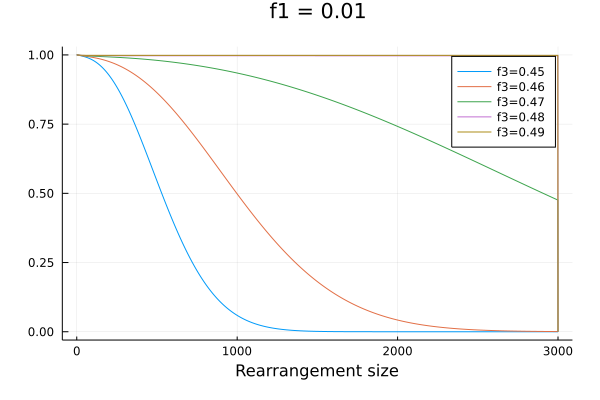

In [304]:
pl2 = Plots.Plot()
for (i,f3) in pairs(f3s)
    plot!(pl2, 0:lastindex(qs2[i]), (1 .- cumsum(qs2[i]))[0:end], label="f3=$(round(f3,digits=3))")
end
xlabel!(pl2,"Rearrangement size")
title!(pl2,"f1 = 0.01")
plot!(pl2, margin=5*Plots.mm)

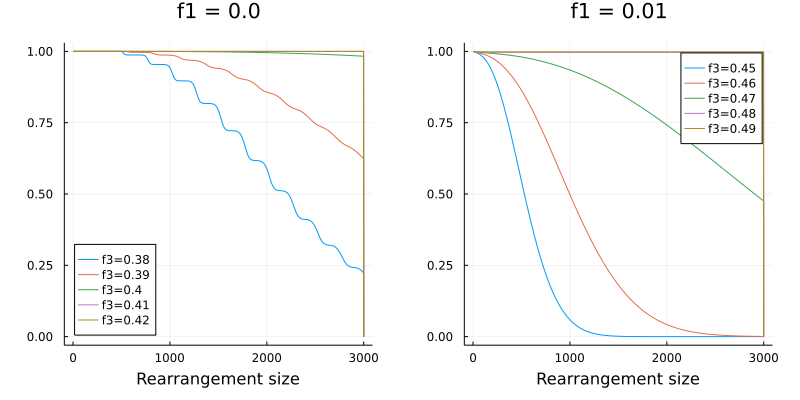

In [305]:
plot(pl1, pl2, size=(800,400))

In [ ]:
plot(-N:N, q)